# Exercise 2: Non-Linearity in Higher Dimensions

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
rng = np.random.default_rng(7)

In [4]:
mu_A = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
Sigma_A = np.array([
    [1.0, 0.8, 0.1, 0.0, 0.0],
    [0.8, 1.0, 0.3, 0.0, 0.0],
    [0.1, 0.3, 1.0, 0.5, 0.0],
    [0.0, 0.0, 0.5, 1.0, 0.2],
    [0.0, 0.0, 0.0, 0.2, 1.0],
], dtype=float)

mu_B = np.array([1.5, 1.5, 1.5, 1.5, 1.5])
Sigma_B = np.array([
    [1.5, -0.7, 0.2, 0.0, 0.0],
    [-0.7, 1.5, 0.4, 0.0, 0.0],
    [0.2, 0.4, 1.5, 0.6, 0.0],
    [0.0, 0.0, 0.6, 1.5, 0.3],
    [0.0, 0.0, 0.0, 0.3, 1.5],
], dtype=float)

nA = 500
nB = 500

In [5]:
XA = rng.multivariate_normal(mu_A, Sigma_A, size=nA)
XB = rng.multivariate_normal(mu_B, Sigma_B, size=nB)

X = np.vstack([XA, XB])
y = np.array([0]*nA + [1]*nB)  # 0 = Class A, 1 = Class B

X_mean = X.mean(axis=0, keepdims=True)
X_std  = X.std(axis=0, keepdims=True) + 1e-8
Xz = (X - X_mean) / X_std

In [12]:
# PCA via SVD on centered data
X_centered = X - X.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
# Principal axes in columns of V
components = Vt[:2]
X_proj = X_centered @ components.T
A = X_proj[y==0]; B = X_proj[y==1]

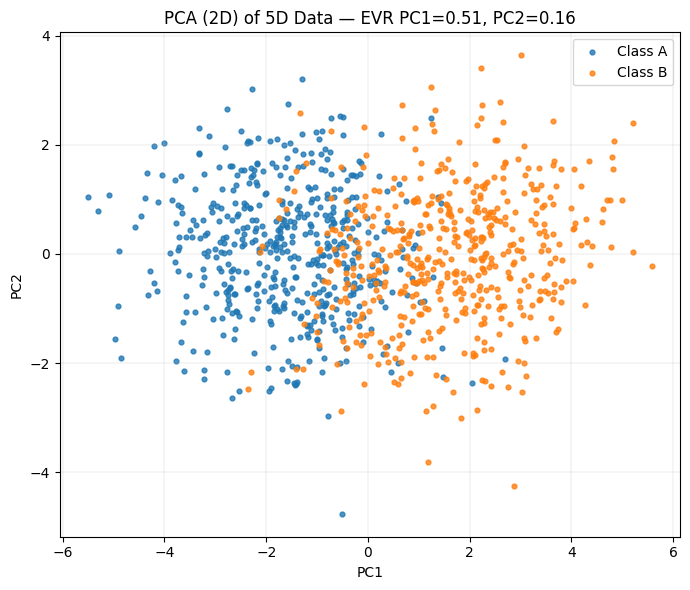

In [13]:
eigs = (S**2) / (X.shape[0] - 1)
explained_variance_ratio = eigs / eigs.sum()
evr_pc1, evr_pc2 = explained_variance_ratio[0], explained_variance_ratio[1]

plt.figure(figsize=(7, 6))
plt.scatter(X_proj[y==0, 0], X_proj[y==0, 1], s=12, alpha=0.8, label="Class A")
plt.scatter(X_proj[y==1, 0], X_proj[y==1, 1], s=12, alpha=0.8, label="Class B")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA (2D) of 5D Data — EVR PC1={evr_pc1:.2f}, PC2={evr_pc2:.2f}")
plt.legend()
plt.grid(True, linewidth=0.3, alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Logistic Regression
def train_logreg(Xz, y, lr=0.08, epochs=300, batch_size=256):
    N, D = Xz.shape
    w = rng.normal(scale=0.01, size=(D,))
    b = 0.0
    idx = np.arange(N)
    for ep in range(epochs):
        rng.shuffle(idx)
        Xs = Xz[idx]; ys = y[idx]
        for i in range(0, N, batch_size):
            xb = Xs[i:i+batch_size]; yb = ys[i:i+batch_size]
            p = sigmoid(xb @ w + b)
            dz = (p - yb) / xb.shape[0]
            grad_w = xb.T @ dz
            grad_b = dz.sum()
            w -= lr * grad_w
            b -= lr * grad_b
    return w, b

w_lr, b_lr = train_logreg(Xz, y, lr=0.08, epochs=300, batch_size=256)

In [ ]:
# Grid em PC1-PC2
x_min, x_max = X_proj[:,0].min()-2, X_proj[:,0].max()+2
y_min, y_max = X_proj[:,1].min()-2, X_proj[:,1].max()+2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 220),
                     np.linspace(y_min, y_max, 220))
grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_5d_center = grid_pca @ components
grid_5d = grid_5d_center + X.mean(axis=0, keepdims=True)
grid_5d_z = (grid_5d - X_mean)/X_std

# LR Predictions
p_lr = sigmoid(grid_5d_z @ w_lr + b_lr).reshape(xx.shape)
Z_lr = (p_lr >= 0.5).astype(int)

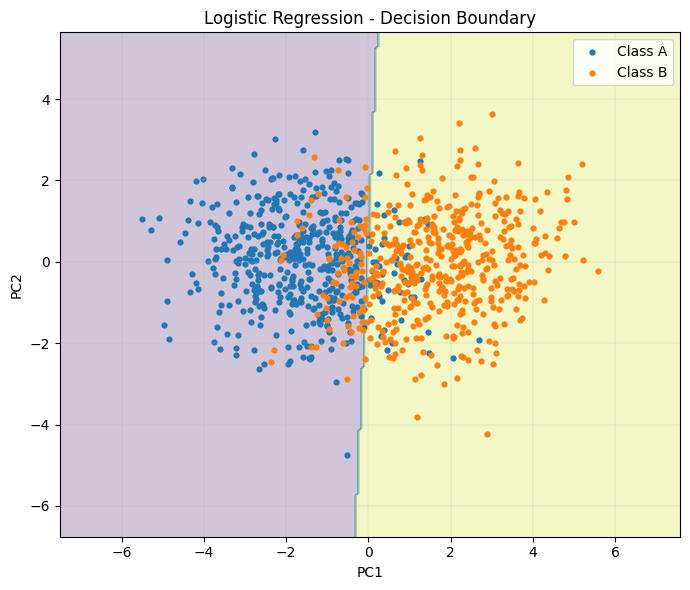

In [17]:
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z_lr, alpha=0.25)
plt.scatter(A[:,0], A[:,1], s=12, label="Class A")
plt.scatter(B[:,0], B[:,1], s=12, label="Class B")
plt.title("Logistic Regression - Decision Boundary")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.grid(True, linewidth=0.3, alpha=0.6)
plt.tight_layout(); plt.show()

# Explanation
### O que o gráfico 1 mostra (relação entre as classes)

- As classes A (μ=0) e B (μ=1.5 em todas as dimensões) ficam deslocadas na projeção PCA, principalmente ao longo do PC1 (que concentra mais variância).

- Ainda assim, há uma faixa de sobreposição considerável entre os pontos — esperado, porque as distribuições são gaussianas com covariâncias diferentes (inclusive correlações opostas em A vs B em algumas dimensões).

### Linear separability (por que é difícil)

- Em 5D, o fronteira ótima de Bayes para duas gaussianas com covariâncias diferentes é quadrática (QDA), não um hiperplano. Isso significa que:

    - Um modelo linear (Perceptron/Regressão Logística/Softmax linear) força uma única fronteira plana; ele tende a errar exatamente nas regiões onde as densidades se sobrepõem de forma curvada.

    - Já um modelo não linear (p.ex., MLP com ReLU/tanh) consegue aproximar superfícies curvas e capturar interações entre dimensões que emergem das correlações cruzadas (p.ex., correlação positiva em A e negativa em B entre x1–x2).

- Em termos práticos: um classificador linear pode até separar parcialmente a projeção (e talvez tenha boa acurácia média), mas não conseguirá modelar a fronteira curvada que minimiza o erro de Bayes.